In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils import get_file

from deepcell.utils.plot_utils import create_rgb_image
from deepcell.datasets import SpotNetExampleData
from deepcell_spots.applications import Polaris

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [2]:
data = SpotNetExampleData()

In [3]:
spots_image, mesmer_image = data.load_data(file='MERFISH_example')
spots_image.shape, mesmer_image.shape

((1, 500, 500, 20), (1, 500, 500, 2))

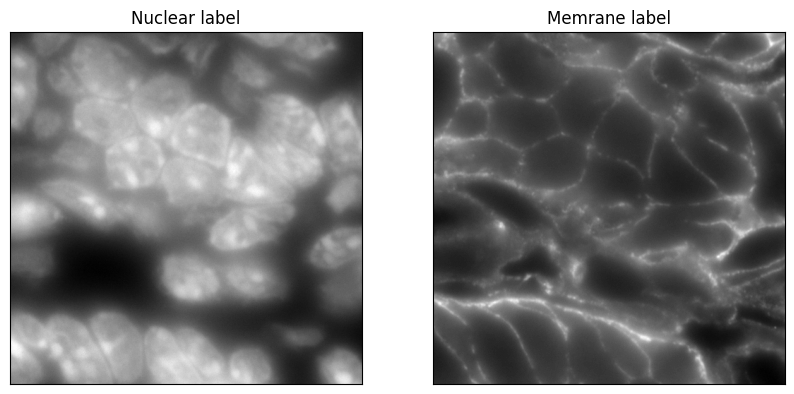

In [4]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(mesmer_image[0,...,0],cmap='gray')
ax[0].set_title('Nuclear label')
ax[1].imshow(mesmer_image[0,...,1],cmap='gray')
ax[1].set_title('Memrane label')

for i in range(np.shape(ax)[0]):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

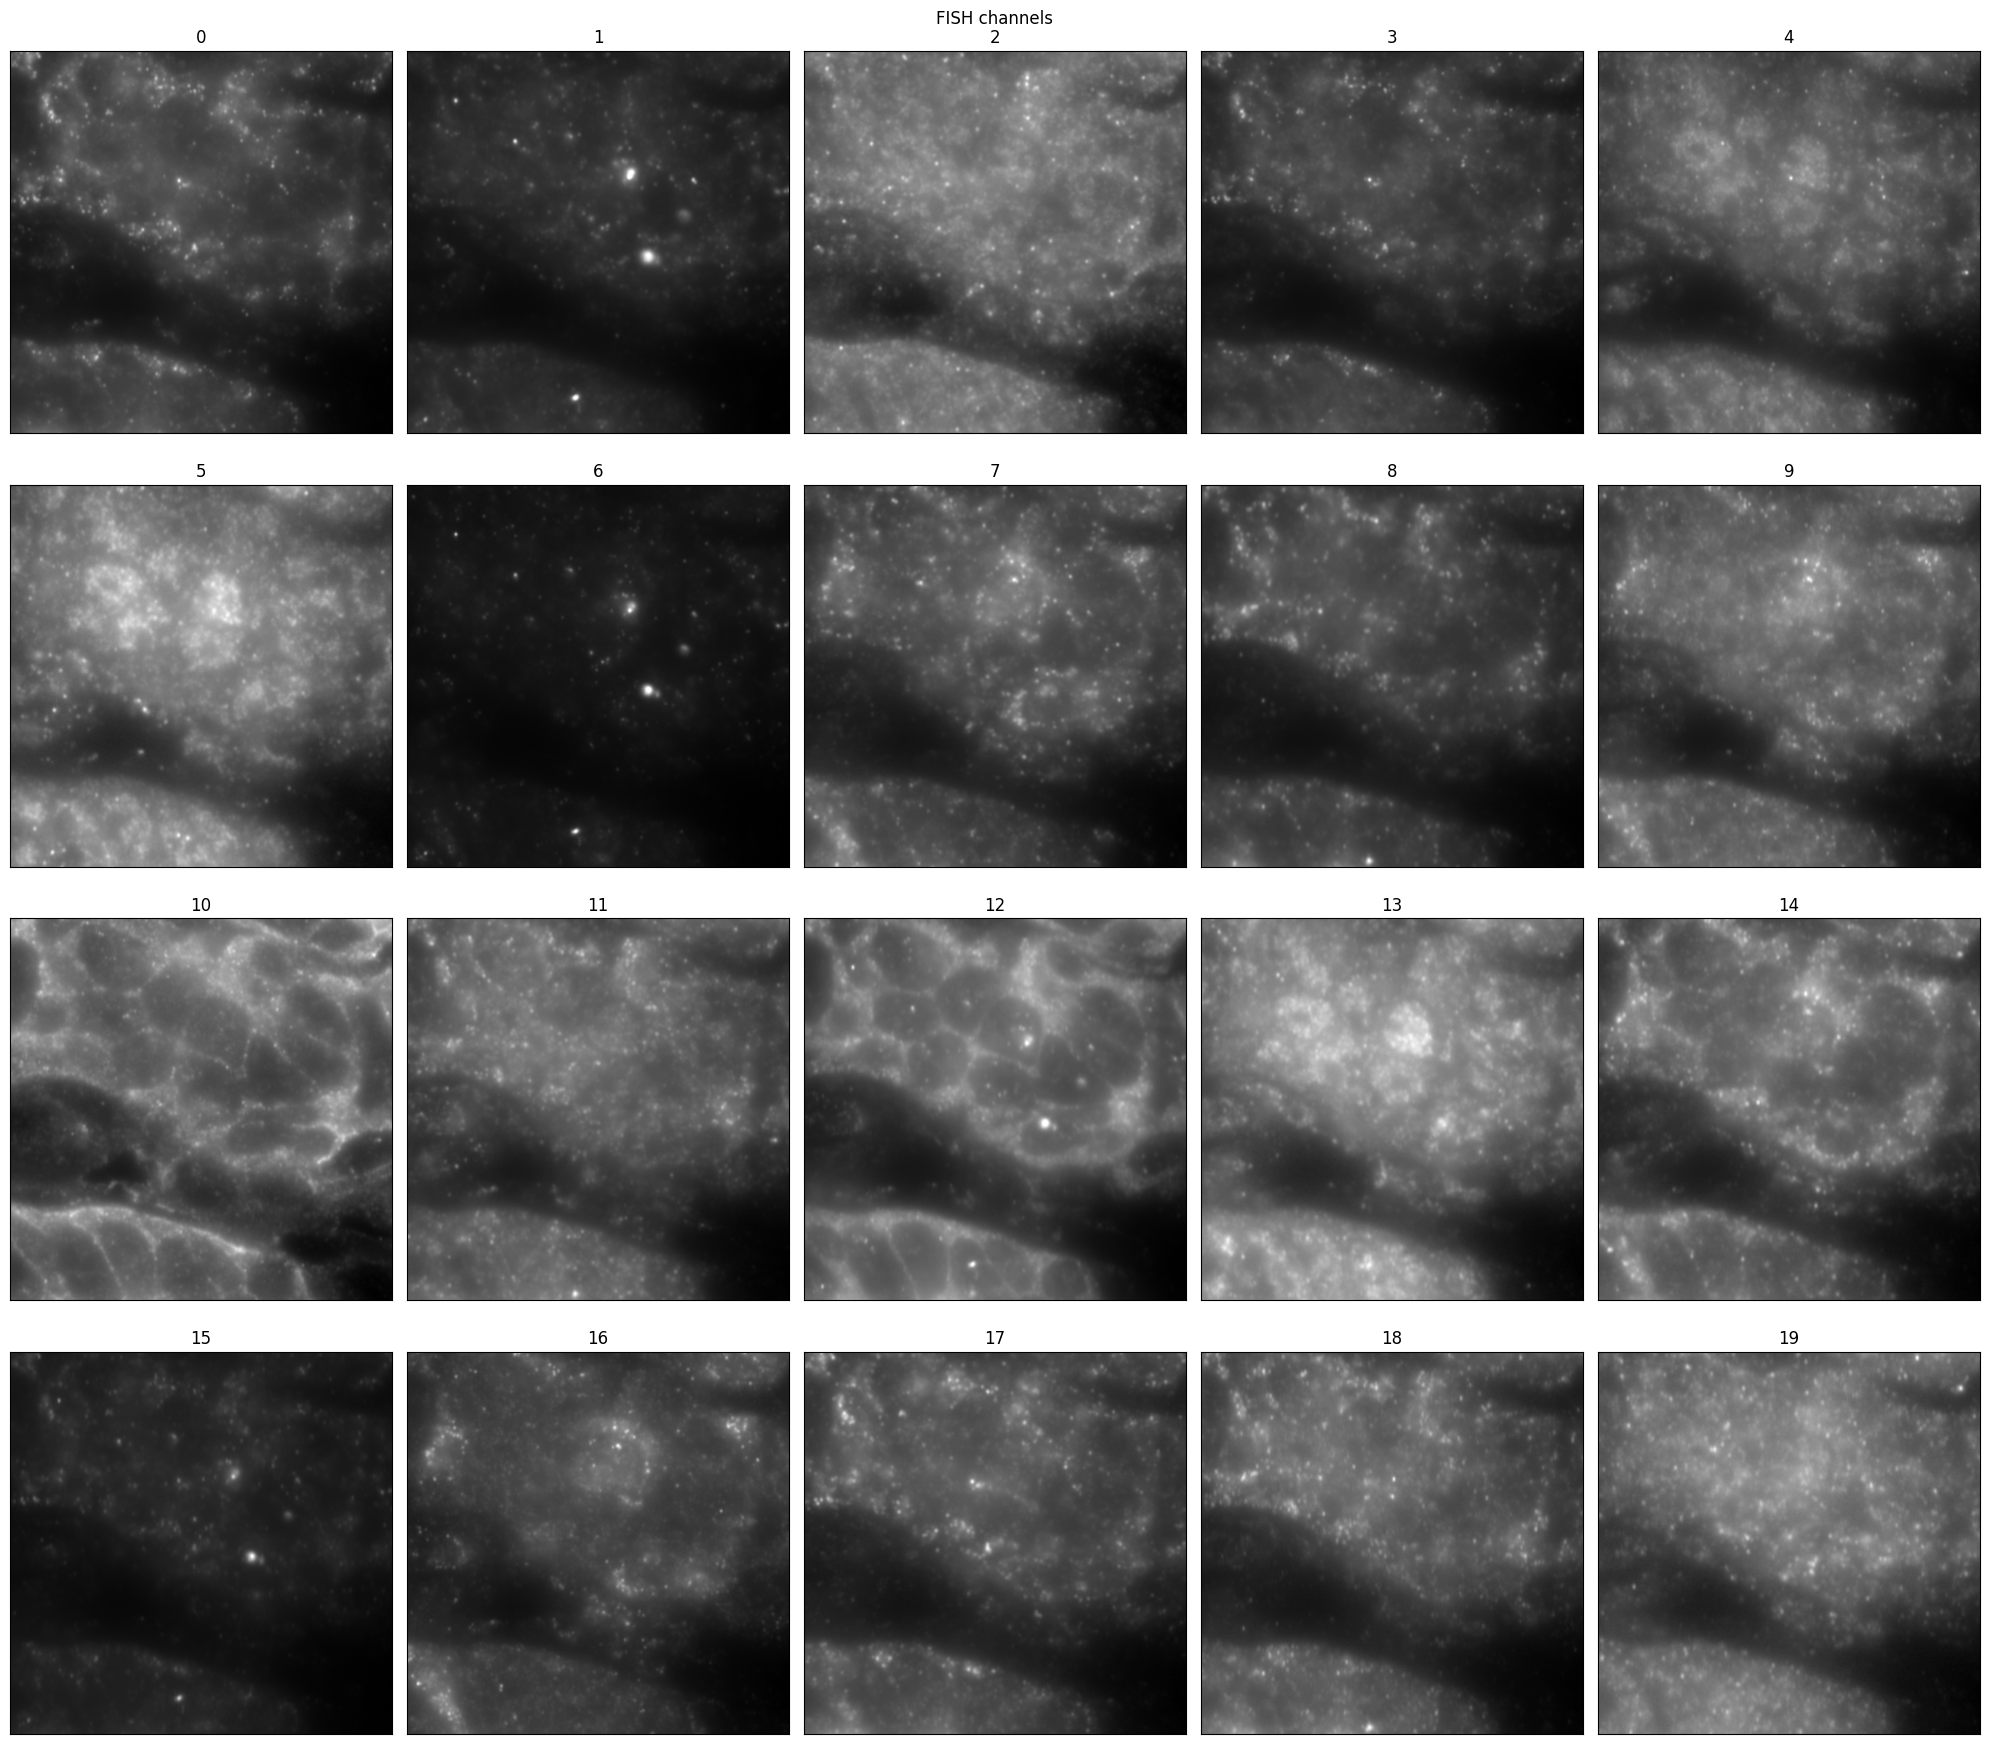

In [5]:
fig,ax = plt.subplots(4,5,figsize=(20, 18))

for idx, ax_d in enumerate(ax.flatten()):
    ax_d.imshow(spots_image[0,..., idx], cmap='gray')
    ax_d.set_title(idx)
    ax_d.set_xticks([])
    ax_d.set_yticks([])

plt.suptitle('FISH channels')
plt.tight_layout()

plt.show()

In [6]:
rounds = 10
channels = 2

df_barcodes = data.load_data(file='MERFISH_codebook')
df_barcodes

Gene  RS0015  RS0083  RS0095  RS0109  RS0175  RS0237  RS0247  RS0255  \
1      Slc51a       0       0       0       1       0       1       0       1   
2        Maoa       0       0       0       1       0       0       0       0   
3       Hmgb2       0       1       0       0       0       0       0       0   
4        Cps1       1       0       0       1       0       0       0       0   
5      Txndc5       0       0       0       0       0       0       0       1   
..        ...     ...     ...     ...     ...     ...     ...     ...     ...   
261  Blank-20       0       0       0       0       0       0       0       0   
262  Blank-21       0       0       0       0       0       0       0       0   
263  Blank-22       1       0       0       0       0       0       0       1   
264  Blank-23       1       1       0       0       0       0       0       1   
265  Blank-24       0       0       0       1       0       0       1       0   

     RS0307  ...  RS0343  RS0384  RS0406  RS0451  RS0468  RS0548  RS0578  \
1         0  ...       0       1       0       0       0       0       0   
2         0  ...       0       0       1       0       0       0       0   
3         0  ...       1       0       0       0       0       1       0   
4         0  ...       0       0       0       0       0       1       0   
5         0  ...       0       0       0       0       1       0       1   
..      ...  ...     ...     ...     ...     ...     ...     ...     ...   
261       0  ...       1       1       0       0       0       0       0   
262       0  ...       0       0       1       0       0       0       0   
263       0  ...       0       1       0       1       0       0       0   
264       0  ...       0       0       0       0       0       0       0   
265       1  ...       0       0       0       0       0       0       0   

     RS0584  RS0639  RS0707  
1         0       0       0  
2         1       0       1  
3         0       1       0  
4         1       0       0  
5         0       0       0  
..      ...     ...     ...  
261       1       1       0  
262       1       1       0  
263       0       0       0  
264       0       1       0  
265       0       0       0  

[265 rows x 21 columns]

# Multiplex

Multiplex FISH datasets encode gene identity with a combinatorial barcode created with sequential rounds of fluorescent staining. Analysis of these datasets with Polaris require `decoding_kwargs` such as the number of `rounds` and `channels` used to create the barcode and a codebook (`df_barcodes`) which defines the relationship between the combinatorial barcodes and gene identities.

Valid options for `segmentation_type` include `mesmer` (whole-cell segmentation model for tissue samples), `cytoplasm` (whole-cell model for cell culture samples), `nucleus` (nuclear model for cell culture samples), and `no_segmentation`. 

In [8]:
multiplex_app = Polaris(image_type='multiplex', 
                        segmentation_type='mesmer',
                        decoding_kwargs={'rounds': rounds, 'channels': channels,
                                         'df_barcodes': df_barcodes})

INFO:root:Checking for cached data
INFO:root:Checking SpotDetection-7.tar.gz against provided file_hash...
INFO:root:SpotDetection-7.tar.gz with hash f52d473ad7e4ce33472f1a9a9cae2d85 not found in /root/.deepcell/models
INFO:root:Making request to server
INFO:root:Downloading models/SpotDetection-7.tar.gz with size 18.3 MB to /root/.deepcell/models
18.3MB [00:01, 17.7MB/s]                                                                               
INFO:root:🎉 Successfully downloaded file to /root/.deepcell/models/SpotDetection-7.tar.gz
INFO:root:Extracting /root/.deepcell/models/SpotDetection-7.tar.gz
INFO:root:Successfully extracted /root/.deepcell/models/SpotDetection-7.tar.gz into /root/.deepcell/models
2023-09-04 02:55:33.355488: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operatio

`spots_image` should have the shape (batch, x, y, channel) where the channel dimension is equal to the product of `rounds` and `channels`. `segmentation_image` should have the shape (1, x, y, channel) where channel is equal to 2 (nuclear and membrane images) if `segmentation_type` is `mesmer`, and 1 otherwhise. `image_mpp` is the pixel size of the image in microns. `clip` defines if outlier pixel values are clipped and `threshold` defines the probability threshold for spots.

In [9]:
multiplex_pred = multiplex_app.predict(spots_image=spots_image,
                                       segmentation_image=mesmer_image,
                                       image_mpp=0.11, clip=True, 
                                       threshold=0.85)

INFO:root:Converting image dtype to float
2023-09-04 02:55:51.851565: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float


Training...


100%|████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.44it/s]


Estimating barcode probabilities...


100%|███████████████████████████████████████████████████████████████| 266/266 [00:00<00:00, 523.33it/s]


Revising errors...


9944it [00:36, 271.53it/s]


2029 of 3444 rescue attempts were successful.


In [10]:
df_results = multiplex_pred[0]
segmentation_result = multiplex_pred[1]

In [11]:
df_results

x    y  batch_id  cell_id  spot_index  predicted_id predicted_name  \
5262  198   18         0       16        5262             4           Cps1   
8491  401    4         0       31        8491             6           Klk1   
7362  299  282         0       25        7362             5         Txndc5   
5381  202  291         0       20        5381            54          Stmn1   
5971  233  215         0       20        5971             4           Cps1   
...   ...  ...       ...      ...         ...           ...            ...   
2924   97  300         0       15        2924           116           Cd14   
3118  104   51         0       13        3118            87           Trdc   
9093  443  216         0       35        9093            27            Pzp   
8230  385    5         0       31        8230            10        Slc12a2   
127     3  118         0        6         127            53          Mki67   

      probability        source         0  ...        10        11        12  \
5262     0.999801    prediction  0.989469  ...  0.019306  0.010427  0.009779   
8491     0.993184    prediction  0.000782  ...  0.006872  0.059896  0.164372   
7362     1.000000    prediction  0.000764  ...  0.016004  0.046585  0.012954   
5381     0.999339    prediction  0.988928  ...  0.011578  0.429875  0.051649   
5971     0.999877    prediction  0.983260  ...  0.486728  0.004050  0.042030   
...           ...           ...       ...  ...       ...       ...       ...   
2924     0.999541    prediction  0.635372  ...  0.099564  0.007214  0.013808   
3118     0.880196  error rescue  0.110185  ...  0.023868  0.032573  0.298762   
9093     0.686989  error rescue  0.003666  ...  0.004220  0.034741  0.013269   
8230     0.990913    prediction  0.000477  ...  0.004693  0.000972  0.004433   
127      0.956138    prediction  0.002637  ...  0.057606  0.006625  0.011780   

            13        14        15        16        17        18        19  
5262  0.001311  0.669632  0.970973  0.010834  0.988954  0.011236  0.008119  
8491  0.013769  0.007321  0.000051  0.990646  0.197881  0.020768  0.935381  
7362  0.001794  0.973122  0.000090  0.989041  0.003535  0.020127  0.003854  
5381  0.028495  0.977006  0.000686  0.044484  0.023980  0.971882  0.383781  
5971  0.019065  0.002334  0.958685  0.634560  0.988894  0.251190  0.071666  
...        ...       ...       ...       ...       ...       ...       ...  
2924  0.009798  0.029150  0.001720  0.465029  0.858865  0.003928  0.005619  
3118  0.022356  0.006947  0.000659  0.858487  0.571888  0.095984  0.022836  
9093  0.542461  0.000963  0.001678  0.001173  0.014015  0.004551  0.001675  
8230  0.001301  0.004629  0.000499  0.397331  0.442597  0.102449  0.348369  
127   0.026880  0.000885  0.000354  0.006296  0.007179  0.005002  0.513556  

[1262 rows x 29 columns]

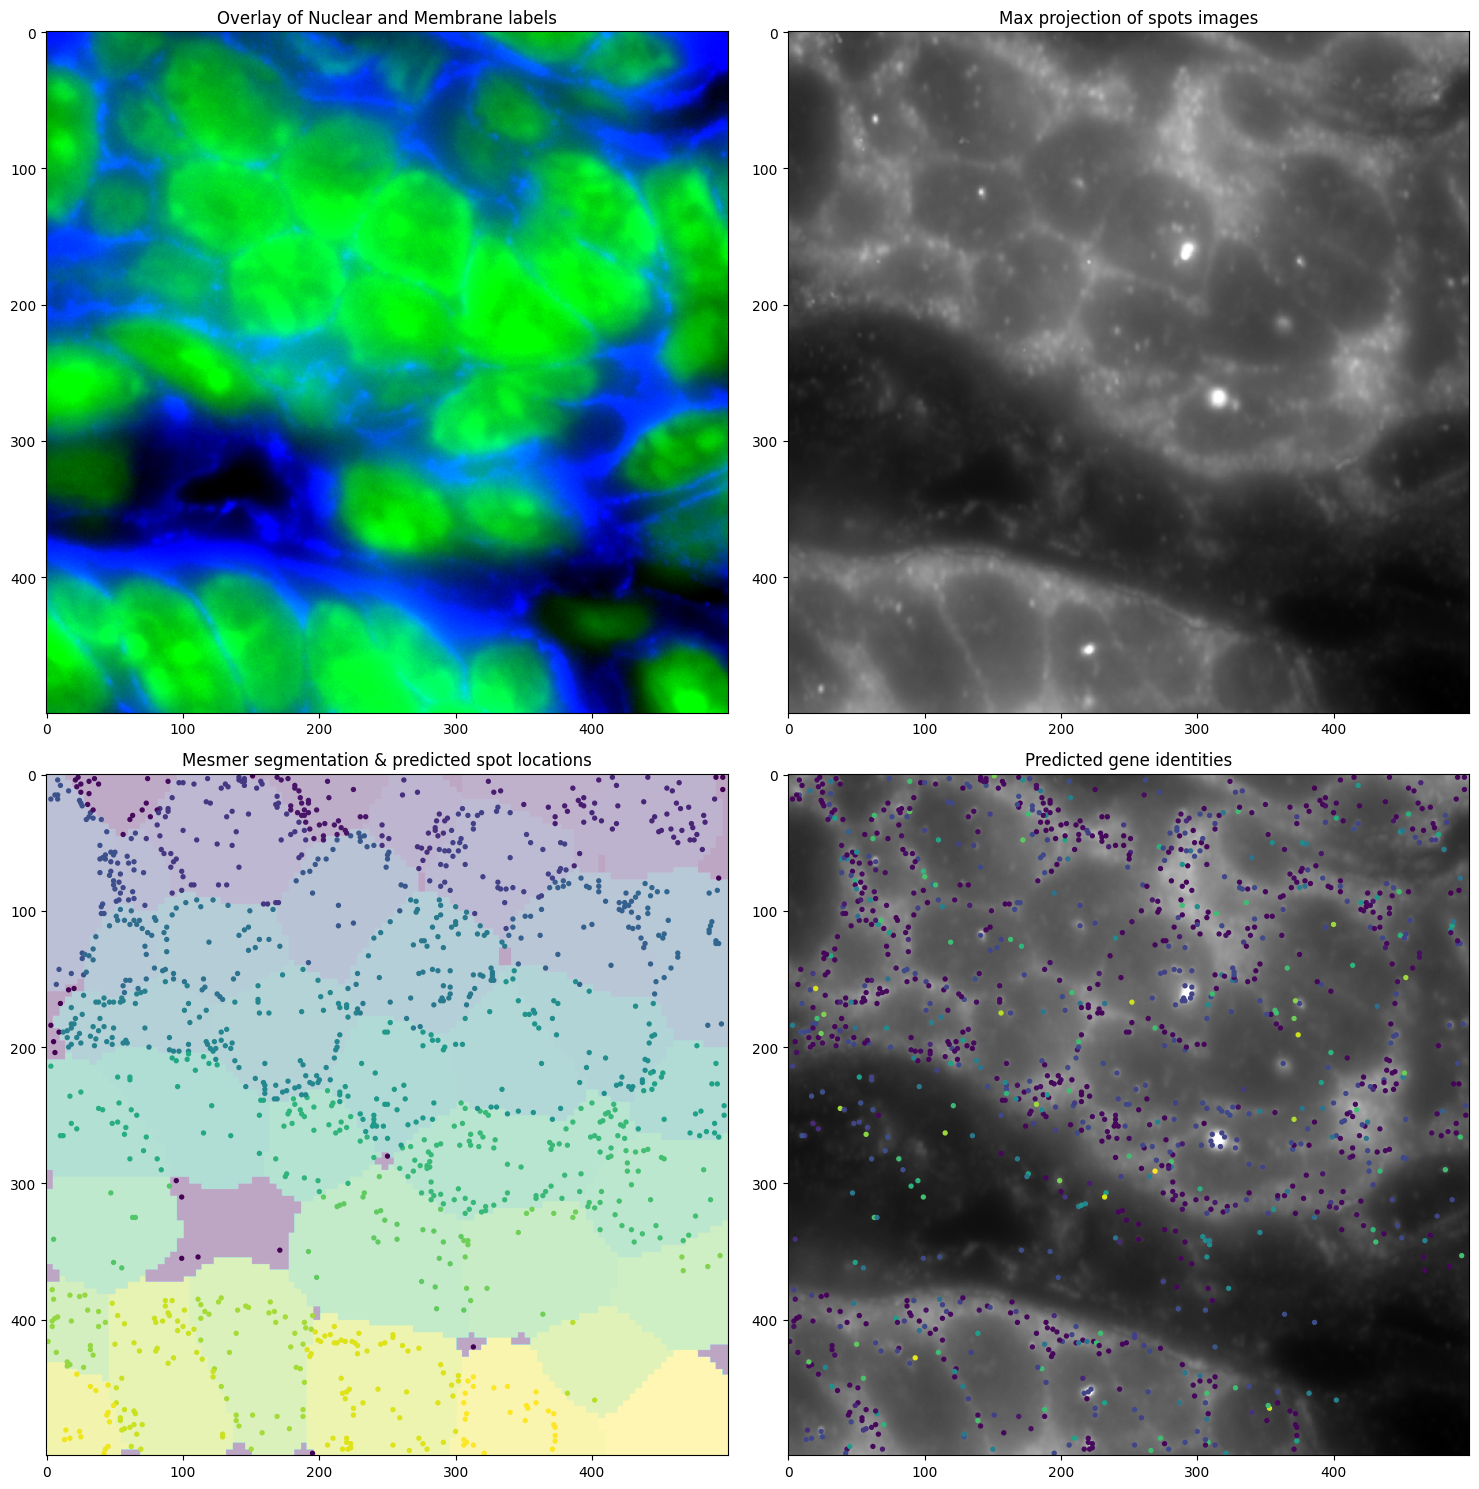

In [14]:
rgb_images = create_rgb_image(mesmer_image, channel_colors=['green', 'blue'])

fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].imshow(rgb_images[0,...])
ax[0,0].set_title('Overlay of Nuclear and Membrane labels')
ax[1,0].imshow(segmentation_result[0,...,0], cmap='viridis', alpha=0.35)
ax[1,0].scatter(df_results.y, df_results.x, c=df_results.cell_id, cmap='viridis', s=8)
ax[1,0].set_title('Mesmer segmentation & predicted spot locations')
ax[0,1].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[0,1].set_title('Max projection of spots images')
ax[1,1].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[1,1].scatter(df_results.y, df_results.x, c=df_results.predicted_id, cmap='viridis', s=8)
ax[1,1].set_title('Predicted gene identities')

plt.tight_layout()
plt.show()

# Singleplex

The singleplex `image_type` for Polaris performs spot detection, iterating through batches and channels, without assigning barcode identities to the spots. Its implementation is identical to the multiplex version, except `decoding_kwargs` does not need to be defined.

In [15]:
singleplex_app = Polaris(image_type='singleplex', 
                         segmentation_type='mesmer')

INFO:root:Checking for cached data
INFO:root:Checking SpotDetection-7.tar.gz against provided file_hash...
INFO:root:SpotDetection-7.tar.gz with hash f52d473ad7e4ce33472f1a9a9cae2d85 not found in /root/.deepcell/models
INFO:root:Making request to server
INFO:root:Downloading models/SpotDetection-7.tar.gz with size 18.3 MB to /root/.deepcell/models
18.3MB [00:00, 42.9MB/s]                                                                               
INFO:root:🎉 Successfully downloaded file to /root/.deepcell/models/SpotDetection-7.tar.gz
INFO:root:Extracting /root/.deepcell/models/SpotDetection-7.tar.gz
INFO:root:Successfully extracted /root/.deepcell/models/SpotDetection-7.tar.gz into /root/.deepcell/models
INFO:root:Checking for cached data
INFO:root:Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
INFO:root:MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
INFO:root:Extracting /root/.deepcell/models/MultiplexSegmentatio

In [16]:
singleplex_pred = singleplex_app.predict(spots_image=spots_image,
                                         segmentation_image=mesmer_image,
                                         image_mpp=0.11, clip=True, 
                                         threshold=0.85)

INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float


In [17]:
df_results = multiplex_pred[0]
segmentation_result = multiplex_pred[1]

In [18]:
df_results

x    y  batch_id  cell_id  spot_index  predicted_id predicted_name  \
5262  198   18         0       16        5262             4           Cps1   
8491  401    4         0       31        8491             6           Klk1   
7362  299  282         0       25        7362             5         Txndc5   
5381  202  291         0       20        5381            54          Stmn1   
5971  233  215         0       20        5971             4           Cps1   
...   ...  ...       ...      ...         ...           ...            ...   
2924   97  300         0       15        2924           116           Cd14   
3118  104   51         0       13        3118            87           Trdc   
9093  443  216         0       35        9093            27            Pzp   
8230  385    5         0       31        8230            10        Slc12a2   
127     3  118         0        6         127            53          Mki67   

      probability        source         0  ...        10        11        12  \
5262     0.999801    prediction  0.989469  ...  0.019306  0.010427  0.009779   
8491     0.993184    prediction  0.000782  ...  0.006872  0.059896  0.164372   
7362     1.000000    prediction  0.000764  ...  0.016004  0.046585  0.012954   
5381     0.999339    prediction  0.988928  ...  0.011578  0.429875  0.051649   
5971     0.999877    prediction  0.983260  ...  0.486728  0.004050  0.042030   
...           ...           ...       ...  ...       ...       ...       ...   
2924     0.999541    prediction  0.635372  ...  0.099564  0.007214  0.013808   
3118     0.880196  error rescue  0.110185  ...  0.023868  0.032573  0.298762   
9093     0.686989  error rescue  0.003666  ...  0.004220  0.034741  0.013269   
8230     0.990913    prediction  0.000477  ...  0.004693  0.000972  0.004433   
127      0.956138    prediction  0.002637  ...  0.057606  0.006625  0.011780   

            13        14        15        16        17        18        19  
5262  0.001311  0.669632  0.970973  0.010834  0.988954  0.011236  0.008119  
8491  0.013769  0.007321  0.000051  0.990646  0.197881  0.020768  0.935381  
7362  0.001794  0.973122  0.000090  0.989041  0.003535  0.020127  0.003854  
5381  0.028495  0.977006  0.000686  0.044484  0.023980  0.971882  0.383781  
5971  0.019065  0.002334  0.958685  0.634560  0.988894  0.251190  0.071666  
...        ...       ...       ...       ...       ...       ...       ...  
2924  0.009798  0.029150  0.001720  0.465029  0.858865  0.003928  0.005619  
3118  0.022356  0.006947  0.000659  0.858487  0.571888  0.095984  0.022836  
9093  0.542461  0.000963  0.001678  0.001173  0.014015  0.004551  0.001675  
8230  0.001301  0.004629  0.000499  0.397331  0.442597  0.102449  0.348369  
127   0.026880  0.000885  0.000354  0.006296  0.007179  0.005002  0.513556  

[1262 rows x 29 columns]

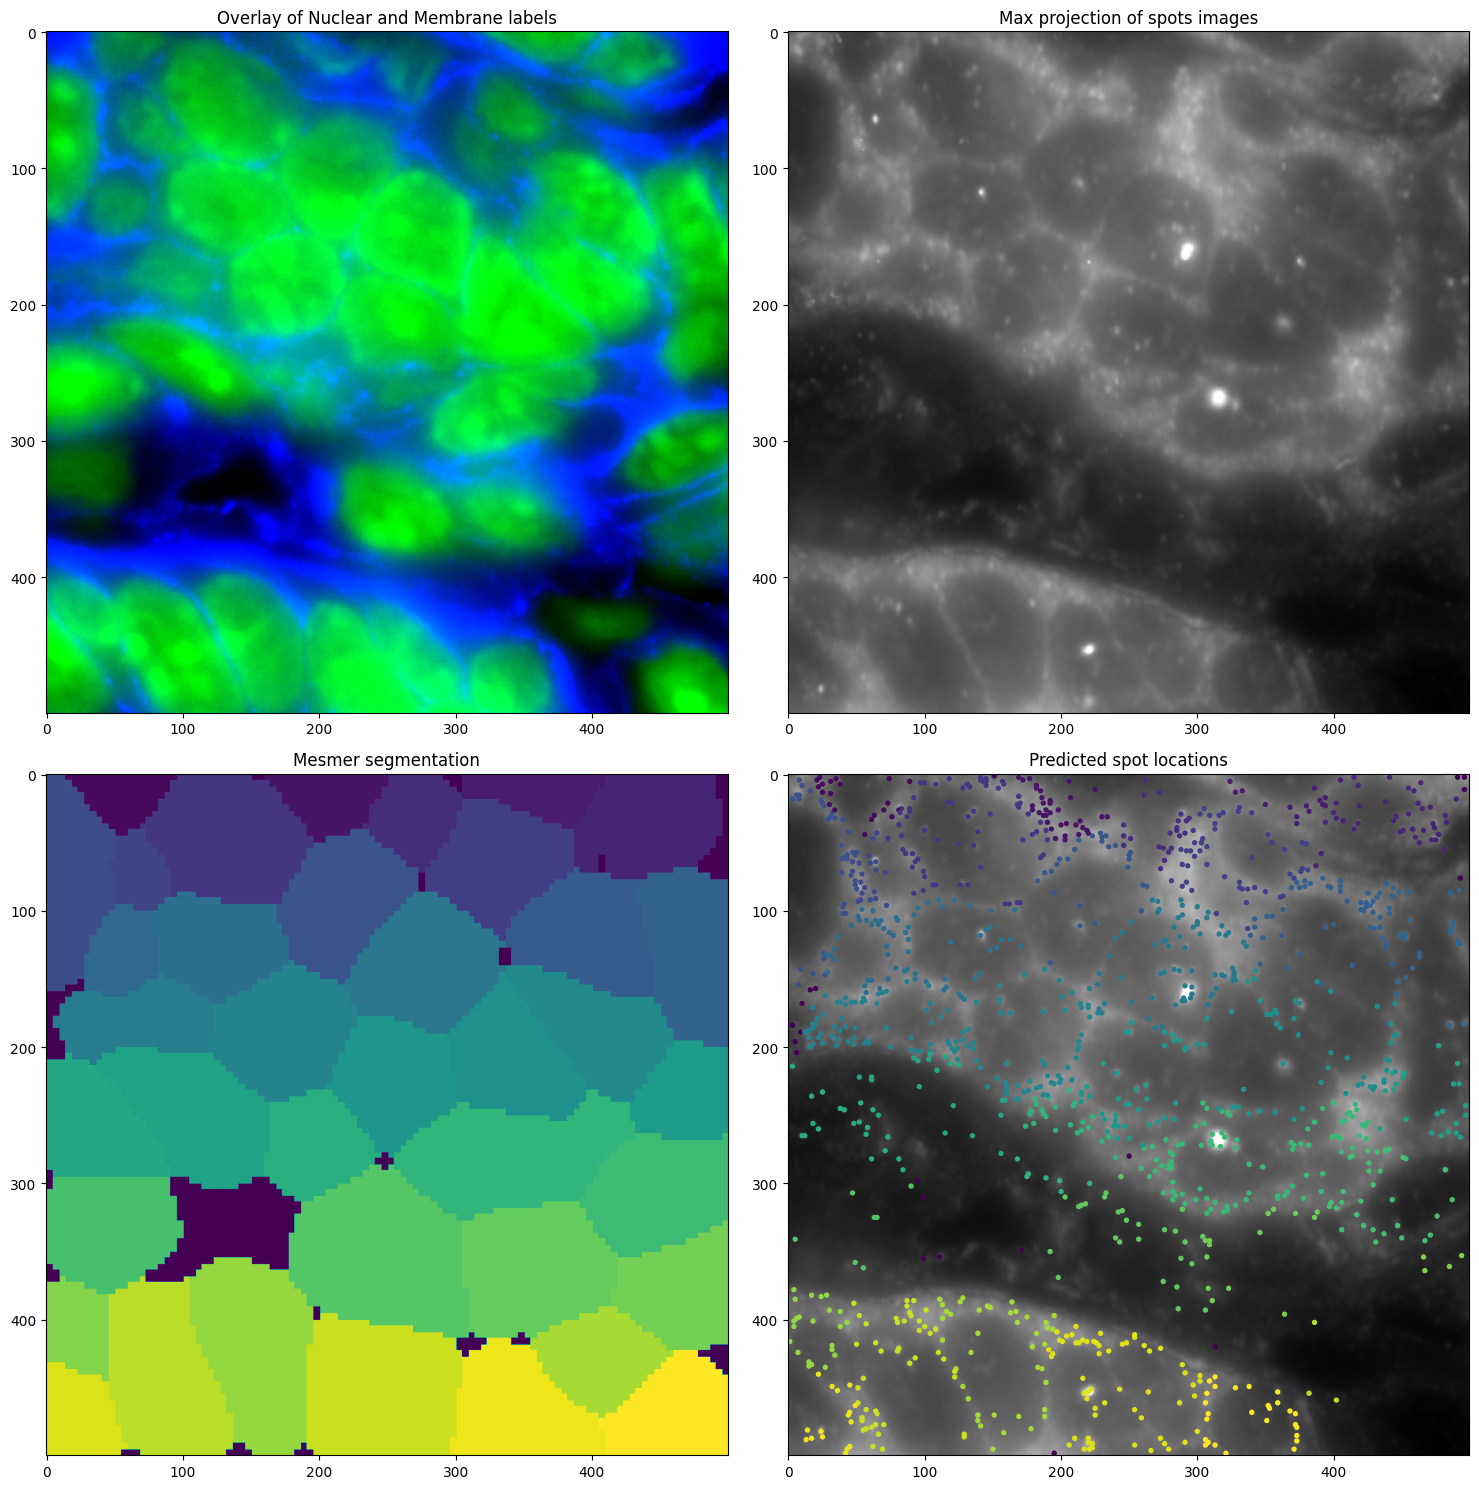

In [19]:
rgb_images = create_rgb_image(mesmer_image, channel_colors=['green', 'blue'])

fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].imshow(rgb_images[0,...])
ax[0,0].set_title('Overlay of Nuclear and Membrane labels')
ax[1,0].imshow(segmentation_result[0,...,0], cmap='viridis', alpha=1)
ax[1,0].set_title('Mesmer segmentation')
ax[0,1].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[0,1].set_title('Max projection of spots images')
ax[1,1].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[1,1].scatter(df_results.y, df_results.x, c=df_results.cell_id, cmap='viridis', s=8)
ax[1,1].set_title('Predicted spot locations')

plt.tight_layout()
plt.show()